# mTRF stimulus reconstruction
**Note:** If you'd like to view the results without training the model, please run the code chunks up to "Select data from one subject and construct dataframes for each vowel" and skip the "Cross-validation" section. Also make sure that you've installed the required packages.

## Load packages and data

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pymtrf.pymtrf.mtrf import mtrf_predict, mtrf_crossval, mtrf_train, lag_gen
from pymtrf.pymtrf.helper import *
from mtrf_model_helpers import *
%matplotlib inline

In [3]:
train_dat = np.load("data_top5v/data_train_top5v.npz")
test_dat = np.load("data_top5v/data_test_top5v.npz")

In [4]:
# Take a look at the files in the training and test data
print("Training data:", train_dat.files)
print("Test data:", test_dat.files)

Training data: ['train_eegs', 'train_envs', 'ipa', 'idnum', 'subject', 'track']
Test data: ['test_eegs', 'test_envs', 'ipa', 'idnum', 'subject', 'track']


In [5]:
# Get the EEGs (XTrain, XTest) and envelopes (YTrain, YTest)
XTrain, YTrain, XTest, YTest = train_dat["train_eegs"], train_dat["train_envs"], test_dat["test_eegs"], test_dat["test_envs"]

In [6]:
# Check the shapes of each dataframe
print("XTrain:", XTrain.shape)
print("YTrain:", YTrain.shape)
print("XTest:", XTest.shape)
print("YTest:", YTest.shape)

XTrain: (66528, 62, 39)
YTrain: (66528, 39)
XTest: (16632, 62, 39)
YTest: (16632, 39)


## Data preprocessing
Reshape the dataframes so that they fit the format required by the mTRF functions.

In [7]:
XTrain = np.transpose(XTrain, (0, 2, 1))
YTrain = np.reshape(YTrain, (YTrain.shape[0], YTrain.shape[1], 1))
XTest = np.transpose(XTest, (0, 2, 1))
YTest = np.reshape(YTest, (YTest.shape[0], YTest.shape[1], 1))

# Check the shapes of the dataframe again
print("XTrain:", XTrain.shape)
print("YTrain:", YTrain.shape)
print("XTest:", XTest.shape)
print("YTest:", YTest.shape)

XTrain: (66528, 39, 62)
YTrain: (66528, 39, 1)
XTest: (16632, 39, 62)
YTest: (16632, 39, 1)


## Select data from one subject and construct dataframes for each vowel

In [8]:
Train_sub_list = train_dat["subject"]
Test_sub_list = test_dat["subject"]

subject = 1

Train_ipa_list = train_dat["ipa"]
Test_ipa_list = test_dat["ipa"]

vowel_list = np.unique(Train_ipa_list)

datasets_by_vowel = {}

for vowel in vowel_list:
    print(vowel)
    datasets_by_vowel[vowel] = {}
    XTrain_tmp = XTrain[np.all([Train_ipa_list == vowel, Train_sub_list == subject], axis = 0), :, :]
    YTrain_tmp = YTrain[np.all([Train_ipa_list == vowel, Train_sub_list == subject], axis = 0), :, :]
    XTest_tmp = XTest[np.all([Test_ipa_list == vowel, Test_sub_list == subject], axis = 0), :, :]
    YTest_tmp = YTest[np.all([Test_ipa_list == vowel, Test_sub_list == subject], axis = 0), :, :]

    ## Combine the training and test sets, since I'll perform 10-fold cross-validation
    datasets_by_vowel[vowel]["XTrain"] = np.concatenate((XTrain_tmp, XTest_tmp), axis = 0)
    datasets_by_vowel[vowel]["YTrain"] = np.concatenate((YTrain_tmp, YTest_tmp), axis = 0)

# Check the shape of each dataframe
for v in datasets_by_vowel.keys():
    print("Vowel:", v)
    print("XTrain shape:", datasets_by_vowel[v]["XTrain"].shape)
    print("YTrain shape:", datasets_by_vowel[v]["YTrain"].shape)
    print("-------")

AE
AH
EH
IH
IY
Vowel: AE
XTrain shape: (589, 39, 62)
YTrain shape: (589, 39, 1)
-------
Vowel: AH
XTrain shape: (2142, 39, 62)
YTrain shape: (2142, 39, 1)
-------
Vowel: EH
XTrain shape: (680, 39, 62)
YTrain shape: (680, 39, 1)
-------
Vowel: IH
XTrain shape: (1298, 39, 62)
YTrain shape: (1298, 39, 1)
-------
Vowel: IY
XTrain shape: (835, 39, 62)
YTrain shape: (835, 39, 1)
-------


## Cross-validation

Perform *k*-fold cross-validation to select the optimal ridge parameter $\lambda$. The number of folds *k* here is 10 and we consider the following lambdas: $\lambda$ = 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000.

In [19]:
k = 10
lambdas = [1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [9]:
for v in datasets_by_vowel.keys():
    cross_validate(datasets_by_vowel[v], k, lambdas, v)
print("Done!")

Running crossvalidation for vowel: AE
  Lambda: 0.001
    Cross-validating fold 1 ...


C:\Users\zg3457\Desktop\B2SDecoder\pymtrf\pymtrf\mtrf.py:123: UserWarning: resp: more features 39 than samples 62, check input dimensions!
  warnings.warn(f'resp: more features {resp.shape[0]} ' +
C:\Users\zg3457\Desktop\B2SDecoder\pymtrf\pymtrf\helper.py:66: UserWarning: X: more features 2542 than samples 39, check input dimensions!
  warnings.warn(f'X: more features {X.shape[1]}' +


      Tested on held-out fold...
      Average correlation: -0.0227760562539484
      Average MSE: 0.0021179574137354415
    Cross-validating fold 2 ...
      Tested on held-out fold...
      Average correlation: 0.019564607411244356
      Average MSE: 0.0019125738268271524
    Cross-validating fold 3 ...
      Tested on held-out fold...
      Average correlation: 0.03735843954226348
      Average MSE: 0.002053373287878135
    Cross-validating fold 4 ...
      Tested on held-out fold...
      Average correlation: -0.024970812449198986
      Average MSE: 0.0021986429834848194
    Cross-validating fold 5 ...
      Tested on held-out fold...
      Average correlation: 0.05807866242872343
      Average MSE: 0.0021443292341706654
    Cross-validating fold 6 ...
      Tested on held-out fold...
      Average correlation: 0.04211957627233426
      Average MSE: 0.0019756880387700976
    Cross-validating fold 7 ...
      Tested on held-out fold...
      Average correlation: 0.020897995739582766

## Results
### Select lambda

Find the lambda that gives the highest correlation for each vowel and the analysis below will include only the results from this lambda value.

Vowel: AE
Index of lambda with max correlation: 0
Index of lambda with min MSE: 0
Vowel: AH
Index of lambda with max correlation: 4
Index of lambda with min MSE: 0
Vowel: EH
Index of lambda with max correlation: 0
Index of lambda with min MSE: 0
Vowel: IH
Index of lambda with max correlation: 7
Index of lambda with min MSE: 0
Vowel: IY
Index of lambda with max correlation: 6
Index of lambda with min MSE: 0
Done!


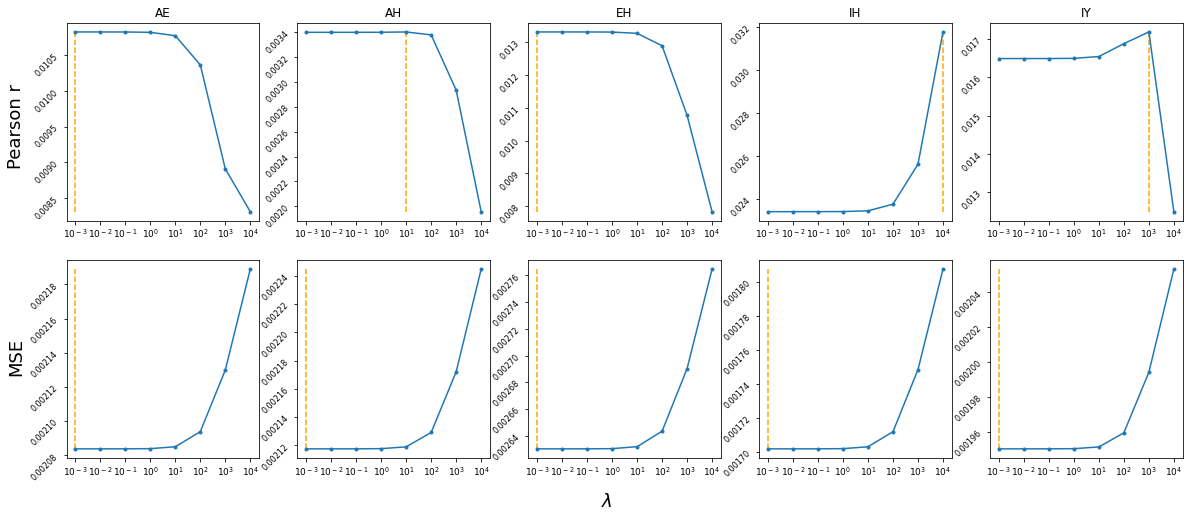

In [9]:
[mtrf_cor_cv_results, mtrf_mse_cv_results, mtrf_coefs_cv_results] = get_mtrf_results()

### Mean correlation across 10 folds for each vowel

In [10]:
for v in mtrf_cor_cv_results:
    print("Mean Pearson correlation r for vowel {}: {}".format(v, np.mean(mtrf_cor_cv_results[v])))

Mean Pearson correlation r for vowel AE: 0.010827839046123593
Mean Pearson correlation r for vowel AH: 0.0034013480162488076
Mean Pearson correlation r for vowel EH: 0.013307501928283283
Mean Pearson correlation r for vowel IH: 0.03175233305612438
Mean Pearson correlation r for vowel IY: 0.01718990302273332


### Mean MSE across 10 folds for each vowel

In [11]:
for v in mtrf_cor_cv_results:
    print("Mean MSE for vowel {}: {}".format(v, np.mean(mtrf_mse_cv_results[v])))

Mean MSE for vowel AE: 0.00208386550006917
Mean MSE for vowel AH: 0.0021189427102227725
Mean MSE for vowel EH: 0.0026301206337255557
Mean MSE for vowel IH: 0.001807722600432634
Mean MSE for vowel IY: 0.0019942093404259798


### Get predictions

In [13]:
mtrf_env_preds = get_mtrf_preds(datasets_by_vowel, mtrf_coefs_cv_results)
np.savez("models/mtrf_env_preds.npz", mtrf_preds = mtrf_env_preds) # save the predicted envelopes

Getting predictions forr vowel: AE
------------- predictions for held-out fold 10...
Getting predictions forr vowel: AH
------------- predictions for held-out fold 10...
Getting predictions forr vowel: EH
------------- predictions for held-out fold 10...
Getting predictions forr vowel: IH
------------- predictions for held-out fold 10...
Getting predictions forr vowel: IY
------------- predictions for held-out fold 10...
Done!


Plot average target envlope and mTRF-predicted envelope for each vowel:

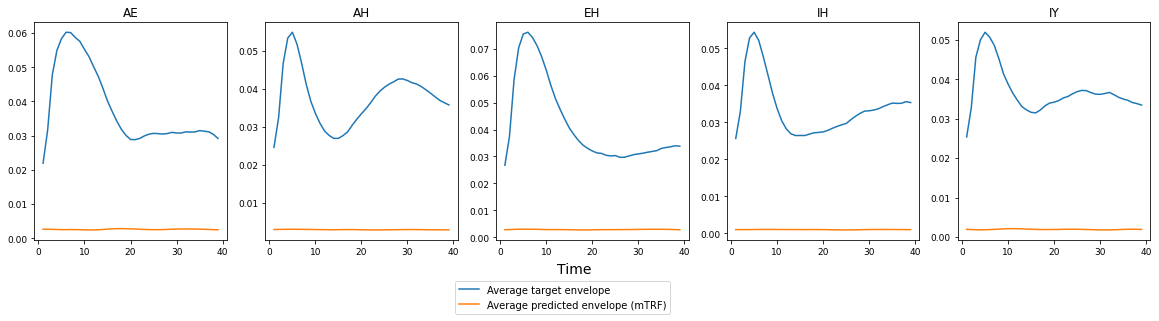

In [14]:
fig, axs = plt.subplots(1, 5, figsize = (20, 4))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
fig.text(0.5, 0.01, "Time", ha = "center", fontsize = 14)
for i, v in enumerate(mtrf_env_preds):
    
    avg_target_env = np.mean(mtrf_env_preds[v]["targets"], axis = 0)
    avg_pred_env = np.mean(mtrf_env_preds[v]["preds"], axis = 0)
    
    t = range(1, len(avg_target_env) + 1)
    
    axs[i].plot(t, avg_target_env, label = "Average target envelope")
    axs[i].plot(t, avg_pred_env, label = "Average predicted envelope (mTRF)")
    axs[i].set_title(v)
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 9)
    handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.57, 0.0))